# **Image Classification of Colon Cancer**

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# !pip install keras-tuner

In [ ]:
! pip install tensorflow-addons

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Assignment2/Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

### **Importing Required Libraries and Reading Data**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow_addons as tfa
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import os
import tempfile
from keras.layers import Activation, Dense
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

In [ ]:
mainData = pd.read_csv('./data_labels_mainData.csv')

In [ ]:
mainData.shape

(9896, 6)

In [ ]:
extraData = pd.read_csv('./data_labels_extraData.csv')

In [ ]:
extraData.shape

(10384, 4)

In [ ]:
mainData.reset_index(drop=True, inplace=True)
extraData.reset_index(drop=True, inplace=True)

In [ ]:
mergedData = pd.concat([mainData, extraData],ignore_index=True)

Merged data for cancer prediction in order to increase the size of the dataset. Neural Network model performs better with more data.

In [ ]:
mergedData.shape

(20280, 6)

In [ ]:
mergedData.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0.0,0
1,22406,1,22406.png,fibroblast,0.0,0
2,22407,1,22407.png,fibroblast,0.0,0
3,22408,1,22408.png,fibroblast,0.0,0
4,22409,1,22409.png,fibroblast,0.0,0


## **Exploratory Data Analysis (EDA)**
Exploring underlying relationship in our data.

### Histogram

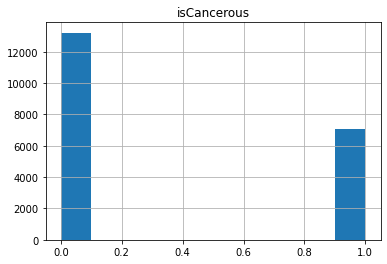

In [ ]:
mergedData.isCancerous.hist()
plt.title('isCancerous')
plt.show()

In [ ]:
mergedData.cellType.hist()
plt.title('cellType')
plt.show()

**Observation:-** Data is heavily imbalanced. Hence, we will be using macro- averaged F1 score as our performance evaluation metric and class weights to give equal weightage to both the classes.

Text(0.5, 1.0, 'Distribution of cancer among patient ids')

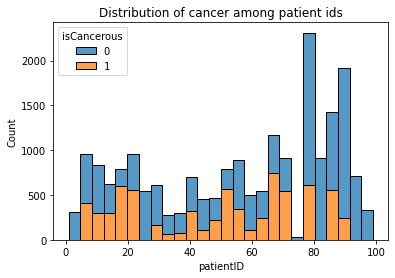

In [ ]:
ax= sns.histplot(mergedData, x="patientID", hue="isCancerous", multiple="stack")
ax.set_title('Distribution of cancer among patient ids')

**Observation:-** Few patient ids have more number of observations than others. Most of them have approximately same number of observations. 
Cancer distribution is almost similar across different pateint ids. Hence, we can use random splitting with stratified sampling

Text(0.5, 1.0, 'Distribution of cancer among cell type')

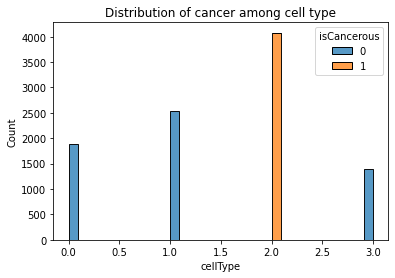

In [ ]:
ax= sns.histplot(mergedData, x="cellType", hue="isCancerous", multiple="stack")
ax.set_title('Distribution of cancer among cell type')

**Observation:-** All the cancer positive patients have cell type 'epithelial'. There are more number of observations belonging to 'epithelial' cell type which shows class imbalance. Hence, we can use class weights while predicting cellType.

In [ ]:
mainData.isnull().values.any()

False

In [ ]:
extraData.isnull().values.any()

False

## **Cancer Prediction**

### **Distribution of classes**

In [ ]:
neg, pos = np.bincount(mergedData['isCancerous'])
total = neg + pos
print('Proportion:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Proportion:
    Total: 20280
    Positive: 7069 (34.86% of total)



### **Splitting Data (Random Splitting)**

In [ ]:
OUTPUT_CLASSES = 2

train_data, test_data = train_test_split(mergedData, test_size=0.2, random_state=42,stratify= mergedData['isCancerous'])
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42,stratify= train_data['isCancerous'])

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


In [ ]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

### **Data Pre-Processing & Augmentation**
1. Applied different data augmentation techniques like horizontal and vertical flipping the image, zooming, changing brighness etc.
2. Rescaled the image.
3. Different color modes like rgb, rgba and grayscale were used. Finally, rgb was chosen as it gave better performance.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5],zoom_range=0.3,
                                   fill_mode='nearest',shear_range=0.2,horizontal_flip=True,vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        # color_mode="grayscale",
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        # color_mode="grayscale",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')


Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


### **Visualizing Data**

In [ ]:
def show_image_samples(gen ):
    train_dict=train_generator.class_indices
    classes=list(train_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<10:   #show maximum of 25 images
        r=length
    else:
        r=10
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

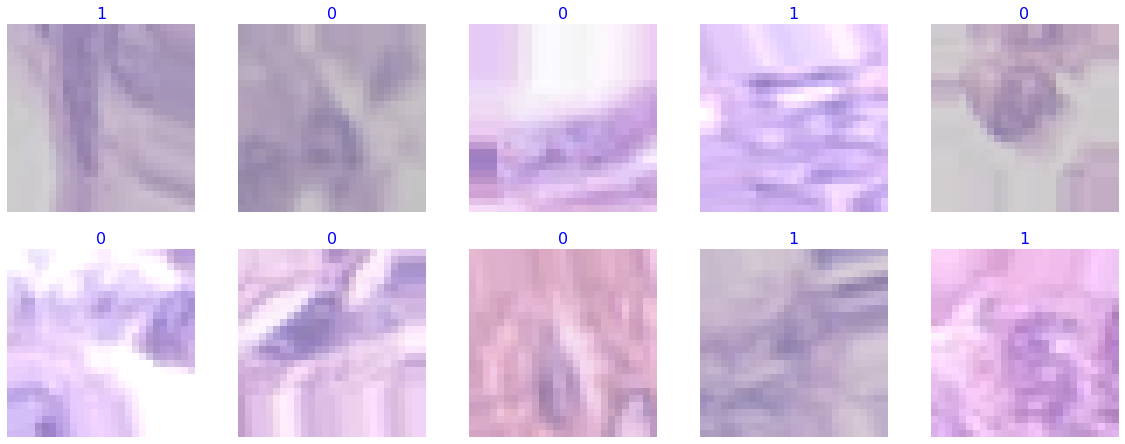

In [ ]:
show_image_samples(train_generator)

### **Learning Curve Plot for Performance Visualization**

In [ ]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.ylim([0,1])
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.ylim([0.3,1])
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### **Performance Evaluation Metric**
1. Macro-averaged F1 score is used in order to deal with class imbalance and give equal importance to both the classes.
2. Accuracy is used to check under/over fitting.
3. Confusion matrix is used to check the number of True Postives, True Negatives, False positives and False Negatives. Our aim is to reduce False Negatives as low as possible.

In [ ]:
METRICS = [
      tfa.metrics.F1Score(num_classes=2,average='macro'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
]

In [ ]:
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

### **Early Stopping**
Early stopping technique is used to stop our model from getting over-fitted.

In [ ]:
# checkpoint = ModelCheckpoint("model_VGG_1_isCancerous.h5", monitor = 'val_accuracy', verbose = 0, save_best_only = True, save_weights_only=False, mode='max', period=1)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=20,
    mode='auto',
    restore_best_weights=True)

### **Plot for comparison of loss between different models**
Used to compare different models' loss.

In [ ]:
mpl.rcParams['figure.figsize'] = (10, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.ylim([0,1])
  plt.legend()

### **Test Data Pre-Processing**

In [ ]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        # color_mode="grayscale",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


### **Function for Test Data Evaluation**
Function for predicting a model's performance on test set.

In [ ]:
def getResult(models):
  y_hat_all = list()
  y_all = list()
  filenames = test_generator.filenames
  N_images = len(filenames)
  batches = 0
  model = models
  # iterate through the data generator and predict for each batch
  # hold the predictions and labels
  for x,y in test_generator:
          y_hat = model.predict(x, verbose=0)
          y_hat = np.argmax(y_hat, axis = 1)
          y = np.argmax(y, axis = 1)
          y_hat_all = y_hat_all + y_hat.tolist()
          y_all = y_all + y.tolist()

          batches += 1
          if batches >= N_images / batch_size:
              # we need to break the loop by hand because
              # the generator loops indefinitely
              break

  result = [y_all,y_hat_all]
  return result
# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

## **Baseline Model**
- CNN is used because it works best for image classification.
- ANN is not chosen because as the number of hidden layers and hidden neurons increases, weights associated with those neurons also increases. This leads to vanishing gradient problem. Hence, feature engineering/extraction becomes important to reduce number of input parameters.
- Without feature engineering is a complex task without much knowledge about the image. Hence, CNN accomplishes this task more efficiently.
- In CNN, feature is extracted on its own through convolutional, max pooling layers.
- Pooling is used to reduce the dimensionality of the feature map.

### **Convolution Neural Network (CNN)**

### VGG16 architecture
- VGG16 is very deep convolutional neural network which is used for Large-Scale Image Recognition. It has achieved top 5 test accuracy in the imagenet competition where it has to classify 1000 classes.
- We have just used first two block from the architecture as our dataset is much smaller and our target size is only 2.
- RELU activation function is used in the input layers in order to avoid negative values and unlike Sigmoid, it doesn't have saturation point at both the extremes. 
- SOFTMAX activation function is used in the output layer to get the probabilities for the classes where probablities add up to 1.

In [ ]:
model_VGG_1_isCancerous = tf.keras.Sequential([
    
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2),strides=(2,2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2),strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [ ]:
model_VGG_1_isCancerous.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

 #### Optimizer and Loss Function
- Adam optimizer
- Binary Cross Entropy

In [ ]:
model_VGG_1_isCancerous.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model_VGG_1_isCancerous.save_weights(initial_weights)

In [ ]:
history_VGG_1_isCancerous = model_VGG_1_isCancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=[early_stopping])

Epoch 1/50
380/381 [============================>.] - ETA: 0s - loss: 0.4909 - f1_score: 0.7212 - accuracy: 0.7655

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


381/381 [==============================] - 45s 34ms/step - loss: 0.4908 - f1_score: 0.7212 - accuracy: 0.7655 - val_loss: 0.4594 - val_f1_score: 0.7316 - val_accuracy: 0.7892
Epoch 2/50
381/381 [==============================] - 12s 32ms/step - loss: 0.4523 - f1_score: 0.7600 - accuracy: 0.7913 - val_loss: 0.5038 - val_f1_score: 0.6187 - val_accuracy: 0.7374
Epoch 3/50
381/381 [==============================] - 12s 32ms/step - loss: 0.4035 - f1_score: 0.7904 - accuracy: 0.8159 - val_loss: 0.4670 - val_f1_score: 0.6664 - val_accuracy: 0.7606
Epoch 4/50
381/381 [==============================] - 12s 32ms/step - loss: 0.3837 - f1_score: 0.8041 - accuracy: 0.8270 - val_loss: 0.4059 - val_f1_score: 0.7743 - val_accuracy: 0.8203
Epoch 5/50
381/381 [==============================] - 12s 32ms/step - loss: 0.3674 - f1_score: 0.8190 - accuracy: 0.8392 - val_loss: 0.4095 - val_f1_score: 0.7770 - val_accuracy: 0.8220
Epoch 6/50
381/381 [==============================] - 12s 32ms/step - loss: 0.357

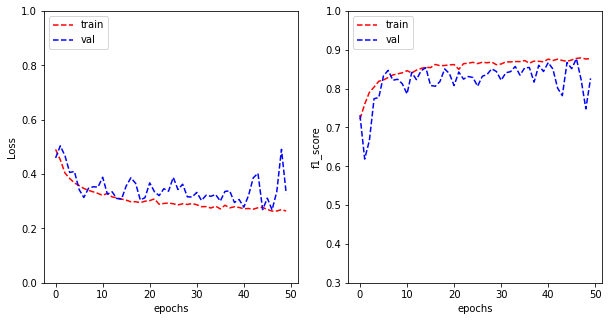

In [ ]:
plot_learning_curve(history_VGG_1_isCancerous.history['loss'], history_VGG_1_isCancerous.history['val_loss'], 
                    history_VGG_1_isCancerous.history['f1_score'], history_VGG_1_isCancerous.history['val_f1_score'], 
                    metric_name='f1_score')

### **Performance on Unseen (Test) Data**

Accuracy score:  0.8636587771203156
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2642
           1       0.92      0.66      0.77      1414

    accuracy                           0.86      4056
   macro avg       0.88      0.82      0.84      4056
weighted avg       0.87      0.86      0.86      4056



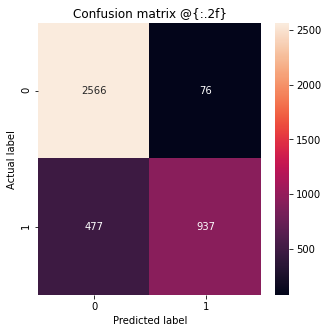

In [ ]:
result = getResult(model_VGG_1_isCancerous)
print("Accuracy score: ", accuracy_score(result[0], result[1]))
target=['0','1']
print(classification_report(result[0], result[1], target_names=target))
plot_cm(result[0], result[1])

**Observation:-** 
- The accuracy of the model is 86.36 which is good.
- There is very little amount of over fitting in the model. The difference between train and validation accuracy is approx 4-5%.
- The learning plot shows some oscillations for validation data. We will try to minimize it further going ahead.
- The macro averaged F1-score is 84% which is not very bad given the imbalance in the data. However, number of False Negatives is very high which needs to be handled as there is health risk associated with it.

In [ ]:
model_VGG_1_isCancerous.save("model_VGG_1_isCancerous")
!cp -R ./model_VGG_1_isCancerous /content/drive/'MyDrive'/Assignment2/

INFO:tensorflow:Assets written to: model_VGG_1_isCancerous/assets


### **Regularization**
- Regularization is applied in order to avoid overfitting and reducing the oscillations in the result. 
- Regularization shrinks the coefficients of the weights of features which are less contributive to the prediction close to 0. 

In [ ]:
reg_lambda = 0.000001

model_VGG_2_isCancerous = tf.keras.Sequential([

    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2),strides=(2,2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2),strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
])

In [ ]:
model_VGG_2_isCancerous.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

### Learning Rate Decay Schedule

In [ ]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)

In [ ]:
model_VGG_2_isCancerous.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model_VGG_2_isCancerous.save_weights(initial_weights)

In [ ]:
history_VGG_2_isCancerous = model_VGG_2_isCancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=[early_stopping])

Epoch 1/50
380/381 [============================>.] - ETA: 0s - loss: 0.4950 - f1_score: 0.7418 - accuracy: 0.7840

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


381/381 [==============================] - 13s 32ms/step - loss: 0.4951 - f1_score: 0.7420 - accuracy: 0.7840 - val_loss: 0.4221 - val_f1_score: 0.7732 - val_accuracy: 0.7927
Epoch 2/50
381/381 [==============================] - 12s 32ms/step - loss: 0.4388 - f1_score: 0.7692 - accuracy: 0.7989 - val_loss: 0.6108 - val_f1_score: 0.5072 - val_accuracy: 0.6908
Epoch 3/50
381/381 [==============================] - 12s 32ms/step - loss: 0.3984 - f1_score: 0.7973 - accuracy: 0.8215 - val_loss: 0.3783 - val_f1_score: 0.8121 - val_accuracy: 0.8358
Epoch 4/50
381/381 [==============================] - 12s 32ms/step - loss: 0.3694 - f1_score: 0.8155 - accuracy: 0.8368 - val_loss: 0.4323 - val_f1_score: 0.7839 - val_accuracy: 0.8220
Epoch 5/50
381/381 [==============================] - 12s 32ms/step - loss: 0.3663 - f1_score: 0.8194 - accuracy: 0.8398 - val_loss: 0.3400 - val_f1_score: 0.8339 - val_accuracy: 0.8570
Epoch 6/50
381/381 [==============================] - 12s 32ms/step - loss: 0.357

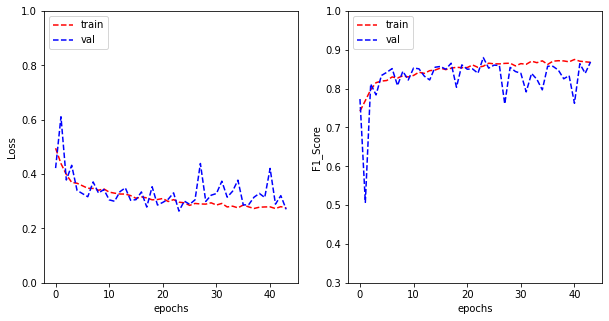

In [ ]:
plot_learning_curve(history_VGG_2_isCancerous.history['loss'], history_VGG_2_isCancerous.history['val_loss'], 
                    history_VGG_2_isCancerous.history['f1_score'], history_VGG_2_isCancerous.history['val_f1_score'], 
                    metric_name='F1_Score')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


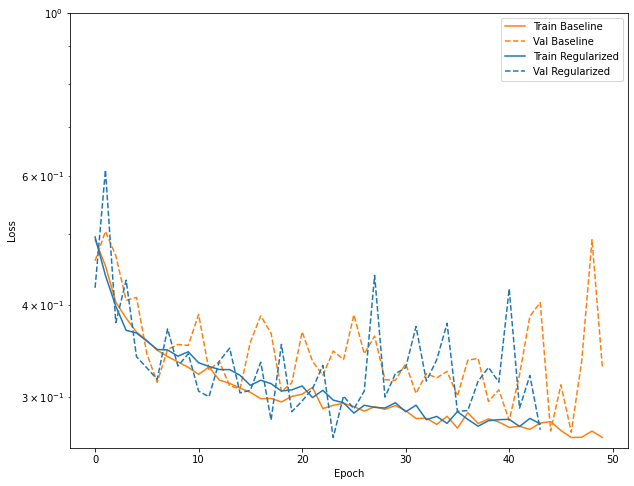

In [ ]:
plot_loss(history_VGG_1_isCancerous, "Baseline", 1)
plot_loss(history_VGG_2_isCancerous, "Regularized", 0)

### **Performance on Unseen (Test) Data**

Accuracy score:  0.8912721893491125
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2642
           1       0.86      0.82      0.84      1414

    accuracy                           0.89      4056
   macro avg       0.88      0.87      0.88      4056
weighted avg       0.89      0.89      0.89      4056



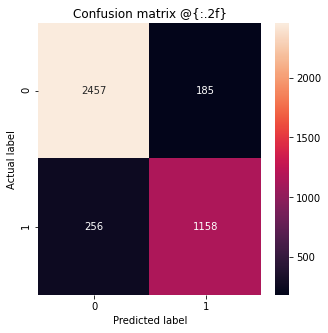

In [ ]:
result = getResult(model_VGG_2_isCancerous)
print("Accuracy score: ", accuracy_score(result[0], result[1]))
target=['0','1']
print(classification_report(result[0], result[1], target_names=target))
plot_cm(result[0], result[1])

**Observation:-** 
- The accuracy of the model on unseen data is 89.12 which is better than our baseline model.
- Overfitting is reduced significatly after using l2 regularization which shrinks the coefficients of the weights of less contributive features close to 0.
- The learning plot shows some oscillations for validation data. However, it is lower than our baseline model. We can see it in the loss comparison plot.
- The macro averaged F1-score is 88% which is far better than our baseline model and the number of False Negatives has also reduced from 477 to 256 which is excellent.
- While doing so, there is a slight increase in the false positives but it is not very significant.

In [ ]:
model_VGG_2_isCancerous.save("model_VGG_2_isCancerous")
!cp -R ./model_VGG_2_isCancerous /content/drive/'MyDrive'/Assignment2/

INFO:tensorflow:Assets written to: model_VGG_2_isCancerous/assets


### **Dropout**
- Used to prevent overfitting. 
- Randomly sets input units of outgoing edges to 0.

In [ ]:
reg_lambda = 0.000001

model_VGG_3_isCancerous = tf.keras.Sequential([

    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2),strides=(2,2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2),strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
])

In [ ]:
model_VGG_3_isCancerous.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

In [ ]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)

In [ ]:
model_VGG_3_isCancerous.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model_VGG_3_isCancerous.save_weights(initial_weights)

In [ ]:
history_VGG_3_isCancerous = model_VGG_3_isCancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=[early_stopping])

Epoch 1/50
380/381 [============================>.] - ETA: 0s - loss: 0.5094 - f1_score: 0.7550 - accuracy: 0.7920

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


381/381 [==============================] - 13s 32ms/step - loss: 0.5097 - f1_score: 0.7546 - accuracy: 0.7917 - val_loss: 0.4565 - val_f1_score: 0.7090 - val_accuracy: 0.7779
Epoch 2/50
381/381 [==============================] - 12s 32ms/step - loss: 0.4632 - f1_score: 0.7556 - accuracy: 0.7877 - val_loss: 0.4614 - val_f1_score: 0.7291 - val_accuracy: 0.7843
Epoch 3/50
381/381 [==============================] - 12s 32ms/step - loss: 0.4174 - f1_score: 0.7873 - accuracy: 0.8138 - val_loss: 0.4920 - val_f1_score: 0.6759 - val_accuracy: 0.7645
Epoch 4/50
381/381 [==============================] - 12s 32ms/step - loss: 0.4107 - f1_score: 0.7954 - accuracy: 0.8194 - val_loss: 0.3479 - val_f1_score: 0.8279 - val_accuracy: 0.8474
Epoch 5/50
381/381 [==============================] - 12s 31ms/step - loss: 0.3847 - f1_score: 0.8078 - accuracy: 0.8298 - val_loss: 0.3400 - val_f1_score: 0.8371 - val_accuracy: 0.8548
Epoch 6/50
381/381 [==============================] - 12s 32ms/step - loss: 0.377

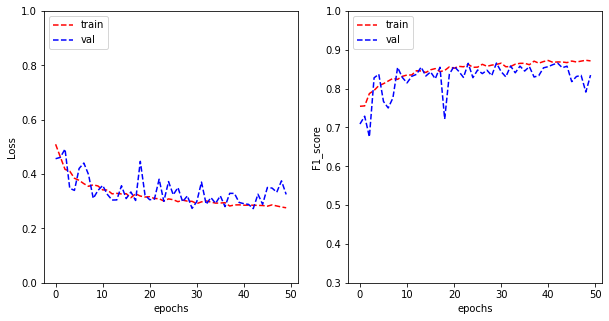

In [ ]:
plot_learning_curve(history_VGG_3_isCancerous.history['loss'], history_VGG_3_isCancerous.history['val_loss'], 
                    history_VGG_3_isCancerous.history['f1_score'], history_VGG_3_isCancerous.history['val_f1_score'], 
                    metric_name='F1_score')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


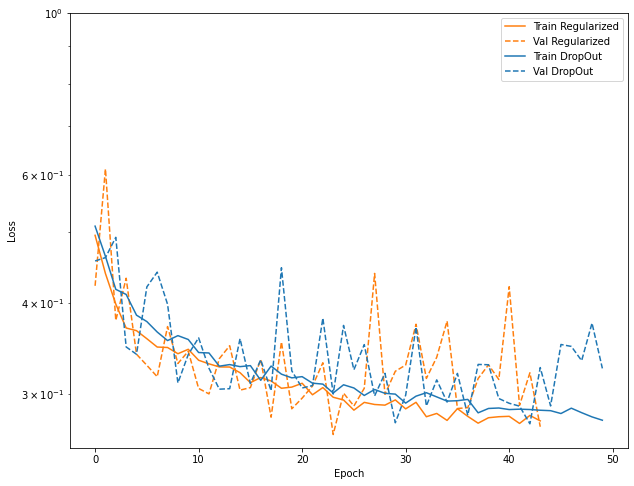

In [ ]:
plot_loss(history_VGG_2_isCancerous, "Regularized", 1)
plot_loss(history_VGG_3_isCancerous, "DropOut", 0)

### **Performance on Unseen (Test) Data**

Accuracy score:  0.8831360946745562
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2642
           1       0.88      0.77      0.82      1414

    accuracy                           0.88      4056
   macro avg       0.88      0.86      0.87      4056
weighted avg       0.88      0.88      0.88      4056



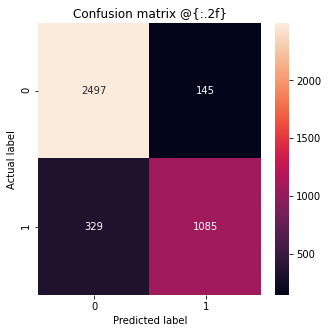

In [ ]:
result = getResult(model_VGG_3_isCancerous)
print("Accuracy score: ", accuracy_score(result[0], result[1]))
target=['0','1']
print(classification_report(result[0], result[1], target_names=target))
plot_cm(result[0], result[1])

**Observation:-** 
- The accuracy of the model on unseen data is 88.31 which is less than the regularized model.
- Overfitting is very low as there is almost negligible difference between the train and validation accuracy.
- The learning plot shows very small oscillations for validation data. However, it is lower than our regularized model which can be seen in the loss comparison plot.
- The macro averaged F1-score is 87% which is better than our baseline model but lower than our regularized model and the number of False Negatives has also increased from 256 to 329.

In [ ]:
model_VGG_3_isCancerous.save("model_VGG_3_isCancerous")
!cp -R ./model_VGG_3_isCancerous /content/drive/'MyDrive'/Assignment2/

INFO:tensorflow:Assets written to: model_VGG_3_isCancerous/assets


### **Class Weights**
- Used to give equal weightage to both the classes.
- Model will penalize more for wrong prediction of minority class.

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes)

In [ ]:
class_weights = dict(enumerate(class_weights))

In [ ]:
class_weights

{0: 0.767503469156049, 1: 1.434567319028531}

In [ ]:
model_VGG_4_isCancerous = tf.keras.models.load_model('model_VGG_3_isCancerous')

In [ ]:
history_VGG_4_isCancerous = model_VGG_4_isCancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=[early_stopping],class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


381/381 [==============================] - 13s 33ms/step - loss: 0.3181 - f1_score: 0.8547 - accuracy: 0.8653 - val_loss: 0.2753 - val_f1_score: 0.8732 - val_accuracy: 0.8841
Epoch 2/50
381/381 [==============================] - 12s 32ms/step - loss: 0.3250 - f1_score: 0.8567 - accuracy: 0.8672 - val_loss: 0.3102 - val_f1_score: 0.8534 - val_accuracy: 0.8671
Epoch 3/50
381/381 [==============================] - 12s 32ms/step - loss: 0.3150 - f1_score: 0.8580 - accuracy: 0.8686 - val_loss: 0.2773 - val_f1_score: 0.8673 - val_accuracy: 0.8814
Epoch 4/50
381/381 [==============================] - 12s 32ms/step - loss: 0.3129 - f1_score: 0.8607 - accuracy: 0.8707 - val_loss: 0.3149 - val_f1_score: 0.8434 - val_accuracy: 0.8671
Epoch 5/50
381/381 [==============================] - 12s 32ms/step - loss: 0.3195 - f1_score: 0.8585 - accuracy: 0.8689 - val_loss: 0.2770 - val_f1_score: 0.8659 - val_accuracy: 0.8824
Epoch 6/50
381/381 [==============================] - 12s 32ms/step - loss: 0.312

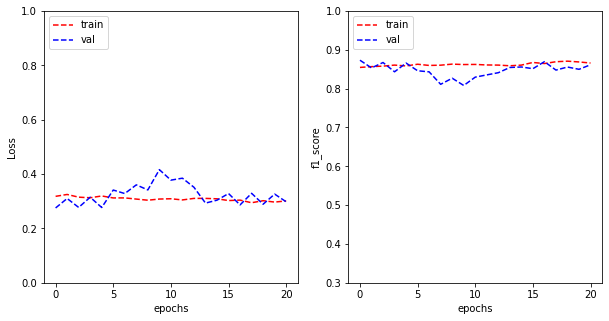

In [ ]:
plot_learning_curve(history_VGG_4_isCancerous.history['loss'], history_VGG_4_isCancerous.history['val_loss'], 
                    history_VGG_4_isCancerous.history['f1_score'], history_VGG_4_isCancerous.history['val_f1_score'], 
                    metric_name='f1_score')

### **Performance on Unseen(Test) Data**

Accuracy score:  0.8875739644970414
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2642
           1       0.83      0.86      0.84      1414

    accuracy                           0.89      4056
   macro avg       0.87      0.88      0.88      4056
weighted avg       0.89      0.89      0.89      4056



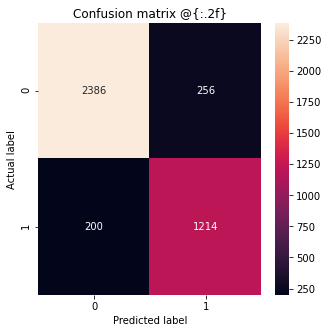

In [ ]:
result = getResult(model_VGG_4_isCancerous)
print("Accuracy score: ", accuracy_score(result[0], result[1]))
target=['0','1']
print(classification_report(result[0], result[1], target_names=target))
plot_cm(result[0], result[1])

**Observation:-** 
- The accuracy of the model on unseen data is 88.75 which is great.
- Overfitting is extremely low as there is almost negligible difference between the train and validation accuracy.
- Oscillations have almost invisible in the learning plot. 
- The macro averaged F1-score is 88% which excellent. 
- The number of False Negatives has also decreased to the lowest i.e. 200 without impacting False Positives much.

In [ ]:
model_VGG_4_isCancerous.save("model_VGG_4_isCancerous")
!cp -R ./model_VGG_4_isCancerous /content/drive/'MyDrive'/Assignment2/

INFO:tensorflow:Assets written to: model_VGG_4_isCancerous/assets


## **Cell Type Prediction**

### **Splitting Data (Random Splitting)**

In [ ]:
OUTPUT_CLASSES = 4

train_data_cellType, test_data_cellType = train_test_split(mainData, test_size=0.2, random_state=42,stratify= mainData['cellType'])
train_data_cellType, val_data_cellType = train_test_split(train_data_cellType, test_size=0.25, random_state=42,stratify= train_data_cellType['cellType'])

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_cellType.shape[0], val_data_cellType.shape[0], test_data_cellType.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [ ]:
train_data_cellType['cellType'] = train_data_cellType['cellType'].astype('str')
val_data_cellType['cellType'] = val_data_cellType['cellType'].astype('str')

### **Data Pre-Processing & Augmentation**

In [ ]:
train_datagen_cellType = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5],zoom_range=0.3,
                                   fill_mode='nearest',shear_range=0.2,horizontal_flip=True,vertical_flip=True)
val_datagen_cellType = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator_cellType = train_datagen_cellType.flow_from_dataframe(
        dataframe=train_data_cellType,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        # color_mode="grayscale",
        batch_size=batch_size,
        class_mode='sparse')

validation_generator_cellType = val_datagen_cellType.flow_from_dataframe(
        dataframe=val_data_cellType,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        # color_mode="grayscale",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


### **Transfer Learning using Cancer Prediction Model**
- Using the best cancer prediction model.
- Benefit is that the cancer prediction model was trained on both main and extra data. Hence, the performance will be better compared to the model just trained on main data.

In [ ]:
model_VGG_1_cellType = tf.keras.models.Sequential(model_VGG_4_isCancerous.layers[:-1])

In [ ]:
model_VGG_1_cellType.add(Dense(OUTPUT_CLASSES, activation ='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))

In [ ]:
model_VGG_1_cellType.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

In [ ]:
model_VGG_1_cellType.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='sparse_categorical_accuracy')

In [ ]:
history_VGG_1_cellType = model_VGG_1_cellType.fit(train_generator_cellType,validation_data=validation_generator_cellType,epochs=30)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


186/186 [==============================] - 7s 32ms/step - loss: 0.9439 - sparse_categorical_accuracy: 0.6190 - val_loss: 0.9010 - val_sparse_categorical_accuracy: 0.6468
Epoch 2/30
186/186 [==============================] - 6s 31ms/step - loss: 0.6780 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.6695 - val_sparse_categorical_accuracy: 0.7534
Epoch 3/30
186/186 [==============================] - 6s 31ms/step - loss: 0.6194 - sparse_categorical_accuracy: 0.7689 - val_loss: 0.6612 - val_sparse_categorical_accuracy: 0.7413
Epoch 4/30
186/186 [==============================] - 6s 31ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.7768 - val_loss: 0.6608 - val_sparse_categorical_accuracy: 0.7327
Epoch 5/30
186/186 [==============================] - 6s 31ms/step - loss: 0.6021 - sparse_categorical_accuracy: 0.7782 - val_loss: 0.7060 - val_sparse_categorical_accuracy: 0.7049
Epoch 6/30
186/186 [==============================] - 6s 32ms/step - loss: 0.5929 - sparse_categorical_acc

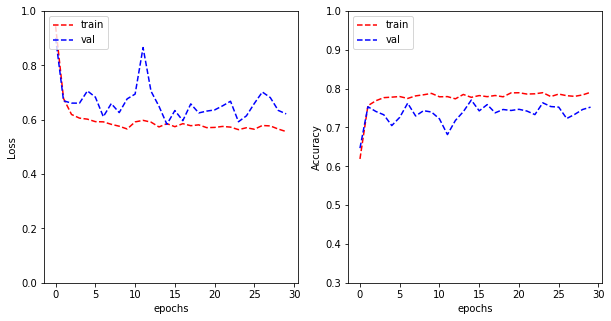

In [ ]:
plot_learning_curve(history_VGG_1_cellType.history['loss'], history_VGG_1_cellType.history['val_loss'], 
                    history_VGG_1_cellType.history['sparse_categorical_accuracy'], history_VGG_1_cellType.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

### **Unseen (Test) Data Evaluation**

In [ ]:
test_data_cellType['cellType'] = test_data_cellType['cellType'].astype('str')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_datagen_cellType = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1
test_generator_cellType = test_datagen_cellType.flow_from_dataframe(
        dataframe=test_data_cellType,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        # color_mode="grayscale",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
y_hat_all = list()
y_all = list()
filenames = test_generator_cellType.filenames
N_images = len(filenames)
batches = 0
  # iterate through the data generator and predict for each batch
  # hold the predictions and labels
for x,y in test_generator_cellType:
  y_hat = model_VGG_1_cellType.predict(x, verbose=0)
  y_hat = np.argmax(y_hat, axis = 1)
  # y = np.argmax(y, axis = 1)
  y_hat_all = y_hat_all + y_hat.tolist()
  y_all = y_all + y.tolist()

  batches += 1
  if batches >= N_images / batch_size:
    break

Accuracy score:  0.7696969696969697
              precision    recall  f1-score   support

           0       0.61      0.83      0.71       375
           1       0.72      0.81      0.76       507
           2       0.90      0.86      0.88       824
           3       0.85      0.34      0.49       274

    accuracy                           0.77      1980
   macro avg       0.77      0.71      0.71      1980
weighted avg       0.79      0.77      0.76      1980



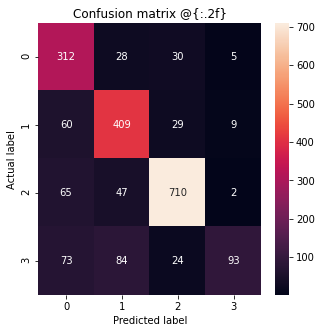

In [ ]:
print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
target=['0','1','2','3']
print(classification_report(y_all, y_hat_all, target_names=target))
plot_cm(y_all, y_hat_all)

**Observation:-** 
- The accuracy of the model on unseen data is 76% which is descent.
- There is slight amount of over fitting i.e. the difference between training and validation accuracy is 3-4%.
- Little oscillations can be seen in the learning plot. 
- The macro averaged F1-score is 71% which also descent. Howeever, if we look at the class 2 i.e. Epithelial, the f1 score is 88% which is good given that most of the cancer cells have cellType as 2.

### **Model 2 without Transfer Learning**
- Developing a similar model and training it just on main data.

In [ ]:
reg_lambda = 0.000001

model_VGG_2_cellType = tf.keras.Sequential([

    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2),strides=(2,2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2),strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
])

In [ ]:
model_VGG_2_cellType.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='sparse_categorical_accuracy')

In [ ]:
history_VGG_2_cellType = model_VGG_2_cellType.fit(train_generator_cellType,validation_data=validation_generator_cellType,epochs=30)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


186/186 [==============================] - 7s 33ms/step - loss: 1.1385 - sparse_categorical_accuracy: 0.5011 - val_loss: 0.9952 - val_sparse_categorical_accuracy: 0.5927
Epoch 2/30
186/186 [==============================] - 6s 31ms/step - loss: 0.9712 - sparse_categorical_accuracy: 0.6101 - val_loss: 1.0541 - val_sparse_categorical_accuracy: 0.5882
Epoch 3/30
186/186 [==============================] - 6s 31ms/step - loss: 0.8871 - sparse_categorical_accuracy: 0.6596 - val_loss: 0.8563 - val_sparse_categorical_accuracy: 0.6549
Epoch 4/30
186/186 [==============================] - 6s 31ms/step - loss: 0.8900 - sparse_categorical_accuracy: 0.6532 - val_loss: 0.7595 - val_sparse_categorical_accuracy: 0.7185
Epoch 5/30
186/186 [==============================] - 6s 32ms/step - loss: 0.8202 - sparse_categorical_accuracy: 0.6865 - val_loss: 0.9194 - val_sparse_categorical_accuracy: 0.6170
Epoch 6/30
186/186 [==============================] - 6s 32ms/step - loss: 0.8188 - sparse_categorical_acc

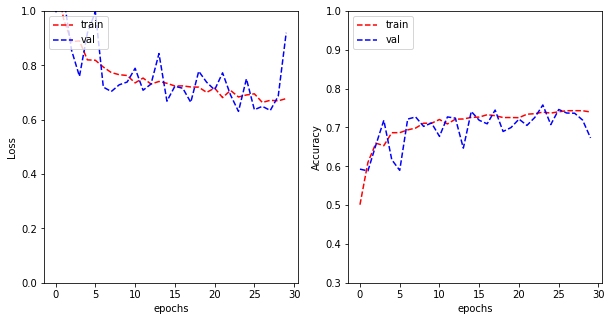

In [ ]:
plot_learning_curve(history_VGG_2_cellType.history['loss'], history_VGG_2_cellType.history['val_loss'], 
                    history_VGG_2_cellType.history['sparse_categorical_accuracy'], history_VGG_2_cellType.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


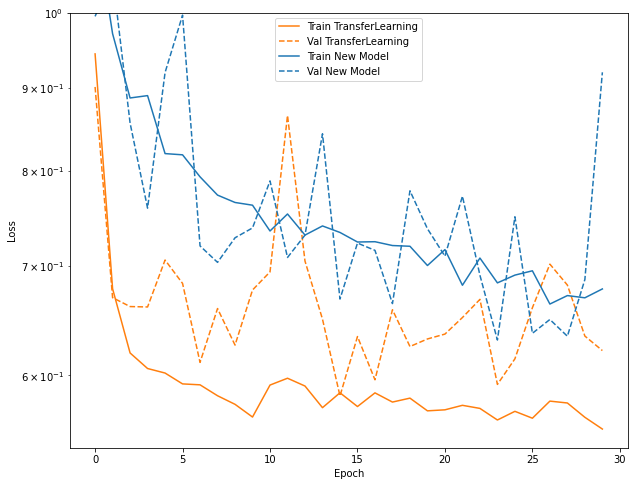

In [ ]:
plot_loss(history_VGG_1_cellType, "TransferLearning", 1)
plot_loss(history_VGG_2_cellType, "New Model", 0)

### **Unseen (Test) Data Evaluation**

In [ ]:
y_hat_all = list()
y_all = list()
filenames = test_generator_cellType.filenames
N_images = len(filenames)
batches = 0
  # iterate through the data generator and predict for each batch
  # hold the predictions and labels
for x,y in test_generator_cellType:
  y_hat = model_VGG_2_cellType.predict(x, verbose=0)
  y_hat = np.argmax(y_hat, axis = 1)
  # y = np.argmax(y, axis = 1)
  y_hat_all = y_hat_all + y_hat.tolist()
  y_all = y_all + y.tolist()

  batches += 1
  if batches >= N_images / batch_size:
    break

Accuracy score:  0.6863636363636364
              precision    recall  f1-score   support

           0       0.60      0.57      0.58       373
           1       0.74      0.65      0.69       497
           2       0.69      0.97      0.81       833
           3       0.89      0.06      0.11       277

    accuracy                           0.69      1980
   macro avg       0.73      0.56      0.55      1980
weighted avg       0.71      0.69      0.64      1980



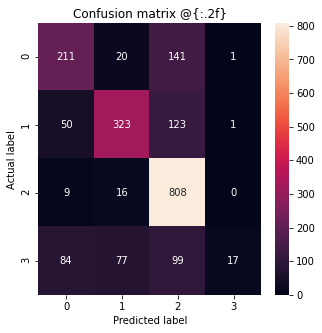

In [ ]:
print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
target=['0','1','2','3']
print(classification_report(y_all, y_hat_all, target_names=target))
plot_cm(y_all, y_hat_all)

**Observation:-** 
- The accuracy of the model on unseen data is just 68.63 which is very low.
- Overfitting is almost same as the tranfer learned model.
- Little oscillations are present in the learning plot. 
- The macro averaged F1-score is 55% which extremely low. 

## **Conclusion**
- Transfer Learning model from cancer prediction is far better than the model just trained on main data.
- This shows that CNN works better with more amount of data.
- Class weights have helped us in balancing the the False negative and False positives. We could have decreased the False negatives further but the cost was huge since there was huge rise in number of false positives.
- Regularization has helped us significatly in reducing the amount of overfitting or over training and increasing the performance.